In [55]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import (RandomForestClassifier,
                              GradientBoostingClassifier,
                              AdaBoostClassifier)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, log_loss, mean_squared_error

In [119]:
import utils as ut 
import calibrator as cal
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [132]:
# params 
test_ratio = 0.2
calibration_ratio = 0.2 

clfs = [
    (LogisticRegression(), 'Logistic Regression'),
    (GradientBoostingClassifier(n_estimators=50), 'Gradient Boosting'),
    (AdaBoostClassifier(DecisionTreeClassifier(max_depth=4), n_estimators=5), 'AdaBoost'),
]


In [6]:
X, y = ut.load_data('credit')

Number of total samples:    30000
Number of positive samples: 6636


## Manual Heuristic
Once the calibration set stops improving, we use the rest of the data for calibration

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=test_ratio)
X_train, X_cal, y_train, y_cal = train_test_split(X_train, y_train, test_size=calibration_ratio)

In [129]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
results = []
clf = Pipeline([('scaler', StandardScaler()), ('lr', LogisticRegression())])
clf_name = 'logistic regression'
calibrator = cal.PlattCalibrator()

for clf, clf_name in clfs: 
    for n in range(1000, len(X_train), 1000): 
        sample_ind = np.random.choice(len(X_train), n, replace=False)
        clf = Pipeline([('scaler', StandardScaler()), (clf_name, clf)])
        clf.fit(X_train[sample_ind], y_train[sample_ind])

        # y_cal
        y_cal_pred = clf.predict_proba(X_cal)[:, 1]
        _, _, K1_cal, K2_cal = ut.expected_calibration_error(y_cal, y_cal_pred, num_bins=B)
        
        # y_test
        y_test_pred = clf.predict_proba(X_test)[:, 1]
        _, _, K1, K2 = ut.expected_calibration_error(y_test, y_test_pred, num_bins=B)

        results.append({
          'mse': mean_squared_error(y_test_pred, y_test), 
          'K1': K1,
          'K2': K2,
          'val_mse': mean_squared_error(y_cal_pred, y_cal), 
          'val_K2': K1_cal, 
          'val_K1': K2_cal, 
          'clf': clf_name,
          'B': B, 
          'n': n,
        'calibrated': "not calibrated"
        })
         
        calibrator.calibrate(clf.predict_proba(X_cal)[:, 1], y_cal)
        
        # y_cal 
        y_cal_pred = calibrator.transform(clf.predict_proba(X_cal)[:, 1])
        _, _, K1_cal, K2_cal = ut.expected_calibration_error(y_cal, y_cal_pred, num_bins=B)

        # y_test
        y_test_pred = calibrator.transform(clf.predict_proba(X_test)[:, 1])
        _, _, K1, K2 = ut.expected_calibration_error(y_test, y_test_pred, num_bins=B)
        
        results.append({
        'mse': mean_squared_error(y_test_pred, y_test), 
        'K1': K1, 
        'K2': K2,
        'val_mse': mean_squared_error(y_cal_pred, y_cal),
        'val_K2': K1_cal,
        'val_K1': K2_cal,
        'clf': clf_name,
        'B': B, 
        'n': n,
        'calibrated': "calibrated"})

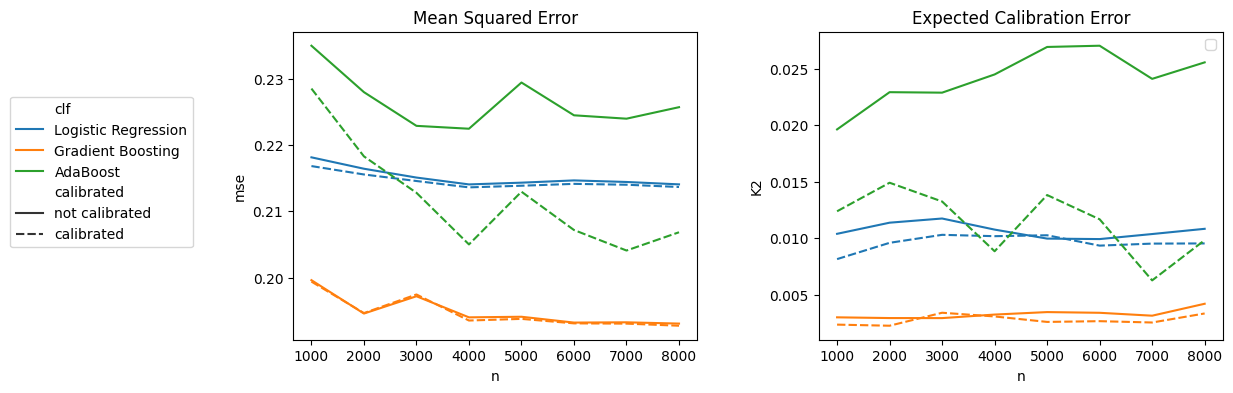

In [131]:
vanilla_results=pd.DataFrame(results)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot the first line plot on the first subplot
sns.lineplot(x='n', y='mse', data=vanilla_results, ax=ax1, hue="clf", style="calibrated")
ax1.set_title('Mean Squared Error')
ax1.legend(loc=(-0.7, 0.3))
# Plot the second line plot on the second subplot
sns.lineplot(x='n', y='K2', data=vanilla_results, ax=ax2, hue="clf", style="calibrated")
ax2.set_title('Expected Calibration Error')
ax2.legend([])

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.3)

# Show the plot
plt.show()

In [138]:
reliab_plot = {}
results = []
gamma = 0.5

calibrator = cal.PlattCalibrator() 

num_iter = 10
for clf, clf_name in clfs:
    for gamma in np.linspace(0.1, 0.9, 10):
        for run in range(5):
            X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2)
            X_train, X_cal, y_train, y_cal = train_test_split(X_train, y_train, test_size=gamma)
            n_tot = len(y_train) + len(y_cal)
            # original clf
            clf = Pipeline([('scaler', StandardScaler()), (clf_name, clf)])
            clf.fit(X_train, y_train)
            
            # y_cal
            y_cal_pred = clf.predict_proba(X_cal)[:, 1]
            _, _, K1_cal, K2_cal = ut.expected_calibration_error(y_cal, y_cal_pred, num_bins=B)

            # y_test
            y_test_pred = clf.predict_proba(X_test)[:, 1]
            mean_prob, mean_true, K1, K2 = ut.expected_calibration_error(y_test, y_test_pred, num_bins=B)

            results.append({
              'mse': mean_squared_error(y_test_pred, y_test), 
              'K1': K1,
              'K2': K2,
              'val_mse': mean_squared_error(y_cal_pred, y_cal), 
              'val_K2': K1_cal, 
              'val_K1': K2_cal, 
              'clf': clf_name,
              'B': B, 
              'n_cal': len(y_cal),
            'n_train': len(y_train), 
              'gamma': gamma, 
            'calibrated': "not calibrated"
            })
            
            reliab_plot[clf_name] = (mean_proba, mean_true)


            # bin calibration
            calibrator.calibrate(clf.predict_proba(X_cal)[:, 1], y_cal)

            # y_cal 
            y_cal_pred = calibrator.transform(clf.predict_proba(X_cal)[:, 1])
            _, _, K1_cal, K2_cal = ut.expected_calibration_error(y_cal, y_cal_pred, num_bins=B)

            # y_test
            y_test_pred = calibrator.transform(clf.predict_proba(X_test)[:, 1])
            _, _, K1, K2 = ut.expected_calibration_error(y_test, y_test_pred, num_bins=B)

            results.append({
            'mse': mean_squared_error(y_test_pred, y_test), 
            'K1': K1, 
            'K2': K2,
            'val_mse': mean_squared_error(y_cal_pred, y_cal),
            'val_K2': K1_cal,
            'val_K1': K2_cal,
            'clf': clf_name,
            'B': B, 
            'n_cal': len(y_cal),
            'n_train': len(y_train),
             'gamma': gamma, 
            'calibrated': "calibrated"})

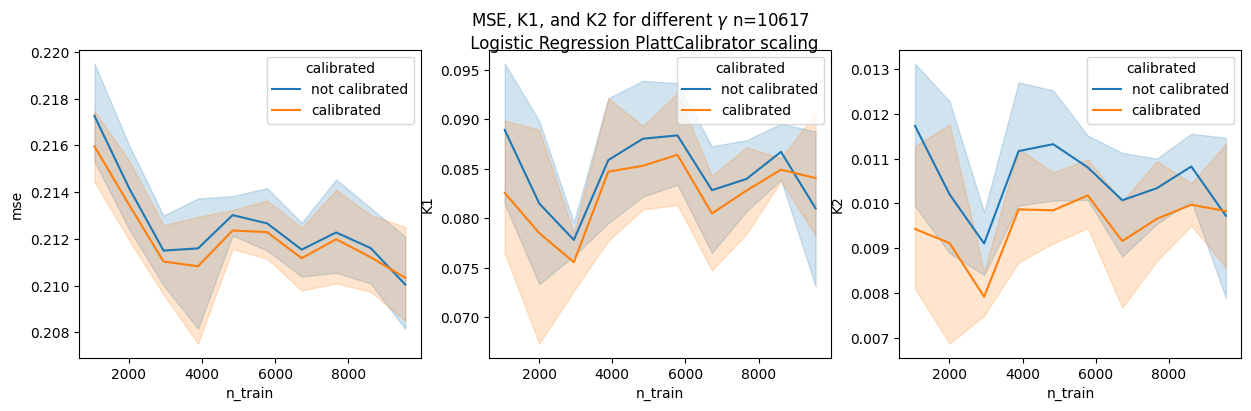

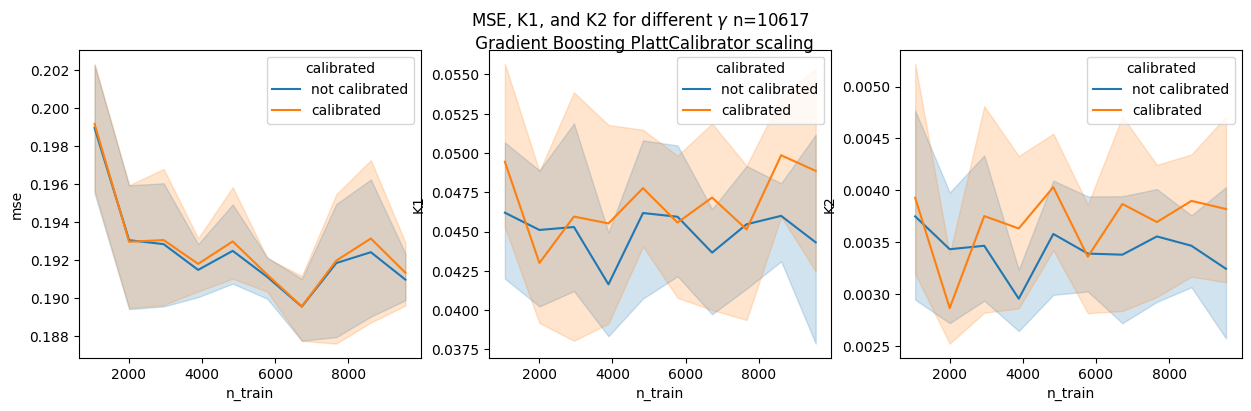

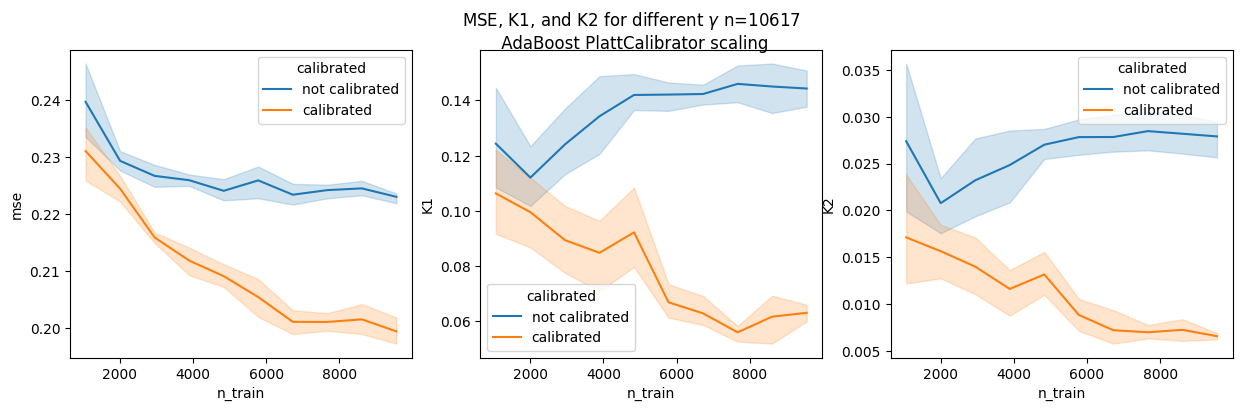

In [140]:
results_df = pd.DataFrame(results)
n_tot = len(X_train) + len(X_cal)
for clf, clf_name in clfs:
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
    sns.lineplot(data=results_df[results_df['clf']==clf_name], x='n_cal', y='mse', hue='calibrated', ax=ax1)
    sns.lineplot(data=results_df[results_df['clf']==clf_name], x='n_train', y='K1', hue='calibrated', ax=ax2)
    sns.lineplot(data=results_df[results_df['clf']==clf_name], x='n_train', y='K2', hue='calibrated', ax=ax3)
    plt.suptitle(f"MSE, K1, and K2 for different $\gamma$ n={n_tot} \n {clf_name} {calibrator.name} scaling")
    plt.show()

Text(0, 0.5, '$E[y]$')

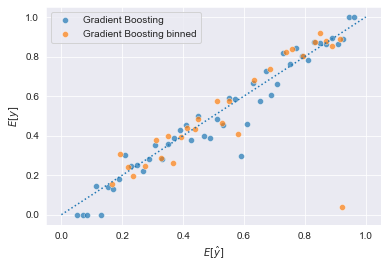

In [10]:
clf_name = "Gradient Boosting"
for name in [clf_name, f"{clf_name} binned"]:
  mean_proba, mean_true = reliab_plot[name]
  sns.scatterplot(x=mean_proba, y=mean_true, alpha=0.7, label=name)

plt.plot([0, 1], [0, 1], label="y=x", linestyle=":")
plt.xlabel(r"$E[\hat{y}]$")
plt.ylabel(r"$E[y]$")

## Competitive Ratio

In [144]:
def CR(mse, calibration_err): 
    pass 

#Todo: plot the CR at different alphas 